## Run SUMMA model ##

Run the SUMMA base model, with the model runs managed by Snakemake

NOTE that the file manager will need to be updated for this workflow to run!!!
Further testing is needed.


### Write snakemake file ###

This block of code writes the snakemake file

In [2]:

from pathlib import Path
import sys
import pysumma as ps
# Import local packages
sys.path.append(str(Path('../').resolve()))


from scripts import gpep_to_summa_utils as gts_utils
config = {}
config['summa_forcing_dir'] = Path('/Users/dcasson/Data/summa_snakemake/bow_above_banff/summa/forcing/')

ens, _ = gts_utils.build_ensemble_list(config['summa_forcing_dir'])
file_paths = gts_utils.list_files_in_subdirectory(config['summa_forcing_dir'])

#Filter files remove those that end in .txt
file_paths = [file for file in file_paths if not file.endswith('.txt')]

forcing_file_list = []
for ens_member in ens:
    # write a new file containing the forcing files which correspond to the ensemble member
    forcing_list_file = f'{config["summa_forcing_dir"]}/forcing_files_{ens_member}.txt'
    with open(forcing_list_file, 'w') as f:
        for file in file_paths:
            #if ensemble member in first three characters of file name
            file_path = Path(file)
            if str(file_path.parent) == ens_member:
                f.write(f'{file}.nc\n')
    forcing_file_list.append(forcing_list_file)


print(ens)
print(file_paths)


{'002', '003', '004', '001', '005'}
['001/rf_static_boxcox_low_predictors_ensMember_001', '003/rf_static_boxcox_low_predictors_ensMember_003', '004/rf_static_boxcox_low_predictors_ensMember_004', '005/rf_static_boxcox_low_predictors_ensMember_005', '002/rf_static_boxcox_low_predictors_ensMember_002']


In [18]:
%%writefile ../rules/run_pysumma_snakemake_test.smk
"""

Snakemake file to run the base SUMMA simulations.

The model simulation is chunked by GRU to allow for parallelization on a cluster.

The chunks of GRUs are defined by the user

"""

from pathlib import Path
import sys
import pysumma as ps
# Import local packages
sys.path.append(str(Path('../').resolve()))

sys.path.append('../')
from scripts import gpep_to_summa_utils as gts_utils

# UPDATE LOCAL SUMMA PATH
config['summa_exe'] = '/Users/dcasson/GitHub/summa/bin/summa.exe'
config['summa_forcing_dir'] = Path('/Users/dcasson/Data/summa_snakemake/bow_above_banff/summa/forcing/')

# Resolve all file paths and directories in the config file
config['file_manager'] = '/Users/dcasson/Data/summa_snakemake/bow_above_banff/summa/settings/fileManager.txt'
config['summa_output_dir'] = '/Users/dcasson/Data/summa_snakemake/bow_above_banff/summa/output'
config['attributes_nc'] = '/Users/dcasson/Data/summa_snakemake/bow_above_banff/summa/attributes.nc'
config['case_name'] = 'bow_above_banff'
config['run_suffix'] = 'base'


ens_set, _ = gts_utils.build_ensemble_list(config['summa_forcing_dir'])
file_paths = gts_utils.list_files_in_subdirectory(config['summa_forcing_dir'])
ens = list(ens_set)

#Filter files remove those that end in .txt
file_paths = [file for file in file_paths if not file.endswith('.txt')]

forcing_file_list = []
for ens_member in ens:
    # write a new file containing the forcing files which correspond to the ensemble member
    forcing_list_file = f'{config["summa_forcing_dir"]}/forcing_files_{ens_member}.txt'
    with open(forcing_list_file, 'w') as f:
        for file in file_paths:
            #if ensemble member in first three characters of file name
            file_path = Path(file)
            if str(file_path.parent) == ens_member:
                f.write(f'{file}.nc\n')
    forcing_file_list.append(forcing_list_file)

rule run_summa_base_simulations:
    input:
        expand(Path(config['summa_output_dir'],f"{config['case_name']}_{{ens_member}}_timestep.nc"),ens_member=ens)

rule run_summa_ensemble_simulations:
    input:
        file_manager = Path(config['file_manager']),
        forcing_file = lambda wildcards: forcing_file_list[ens.index(wildcards.ens_member)]
    output:
        summa_chunked_output = Path(config['summa_output_dir'],f"{config['case_name']}_{{ens_member}}_timestep.nc")
    params:
        summa_exe = config['summa_exe'],
        run_suffix = lambda wildcards: wildcards.ens_member,
    run:
        sim = ps.Simulation(params.summa_exe, input.file_manager)
        print(input.forcing_file)
        sim.force_file_list = str(input.forcing_file)
        print(sim.force_file_list)
        #print(str(params.run_suffix))
        sim.run(run_suffix=str(params.run_suffix), write_config=False)


        

Overwriting ../rules/run_pysumma_snakemake_test.smk


In [17]:
! snakemake --unlock -s ../rules/run_pysumma_snakemake_test.smk #--configfile ../config/gpep_to_summa_tuolumne_config.yaml
! snakemake -s ../rules/run_pysumma_snakemake_test.smk --cores 8 #--configfile ../config/gpep_to_summa_tuolumne_config.yaml


ImportError in file /Users/dcasson/GitHub/PESM/rules/run_pysumma_snakemake_test.smk, line 18:
cannot import name 'gpep_to_summa_utils' from 'scripts' (unknown location)
  File "/Users/dcasson/GitHub/PESM/rules/run_pysumma_snakemake_test.smk", line 18, in <module>
ImportError in file /Users/dcasson/GitHub/PESM/rules/run_pysumma_snakemake_test.smk, line 18:
cannot import name 'gpep_to_summa_utils' from 'scripts' (unknown location)
  File "/Users/dcasson/GitHub/PESM/rules/run_pysumma_snakemake_test.smk", line 18, in <module>


/Users/dcasson/Data/summa_snakemake/bow_above_banff/summa/output/bow_above_banff_004_timestep.nc
/Users/dcasson/Data/summa_snakemake/bow_above_banff/summa/output/bow_above_banff_002_timestep.nc
/Users/dcasson/Data/summa_snakemake/bow_above_banff/summa/output/bow_above_banff_005_timestep.nc
/Users/dcasson/Data/summa_snakemake/bow_above_banff/summa/output/bow_above_banff_003_timestep.nc


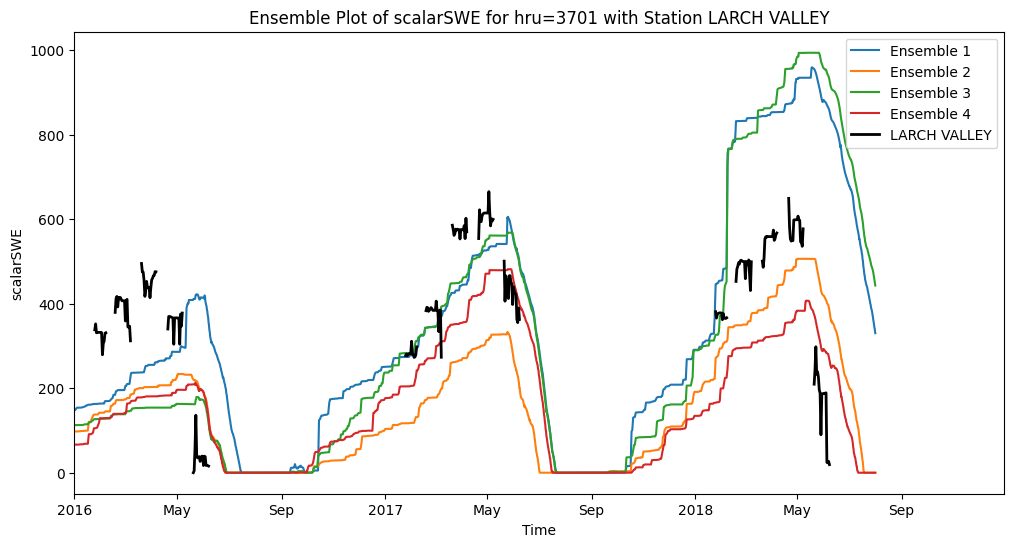

In [3]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def read_station_data(station_file, station_name):
    """
    Reads the station data from a NetCDF file for a specific station.

    Parameters:
    - station_file (str): Path to the NetCDF file containing station data.
    - station_name (str): Name of the station to read.

    Returns:
    - xarray.DataArray: DataArray for the specified station.
    """
    ds = xr.open_dataset(station_file)
    station_names = ds['station_name'].values
    if station_name in station_names:
        station_index = list(station_names).index(station_name)
        return ds.isel(station_id=station_index)['SWE']
    else:
        raise ValueError(f"Station '{station_name}' not found in the file.")

def plot_ensemble_with_station(directory, variable_name, dimension_name, dimension_value, station_file, station_name):
    """
    Reads all NetCDF files in a directory and plots the user-defined variable
    for a specific dimension value from each file as an ensemble, and adds the
    specified station data to the plot. The x-axis represents time.

    Parameters:
    - directory (str): Path to the directory containing NetCDF files.
    - variable_name (str): Name of the variable to plot.
    - dimension_name (str): Name of the dimension to filter.
    - dimension_value (int or str): Value of the dimension to filter.
    - station_file (str): Path to the NetCDF file containing station data.
    - station_name (str): Name of the station to add to the plot.
    """
    # List to hold the datasets
    datasets = []

    # Read all NetCDF files in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.nc'):
            filepath = os.path.join(directory, filename)
            ds = xr.open_dataset(filepath)
            print(filepath)
            datasets.append(ds)

    # Read the station data
    station_data = read_station_data(station_file, station_name)

    # Plot the variable for each dataset
    plt.figure(figsize=(12, 6))
    
    for ds in datasets:
        if variable_name in ds and dimension_name in ds.dims:
            ds_filtered = ds.sel({dimension_name: dimension_value})
            ds_filtered[variable_name].plot.line(x='time', add_legend=True)
    
    # Add the station data to the plot
    station_data.plot.line(x='time', color='black', linewidth=2, label=station_name)

    plt.title(f'Ensemble Plot of {variable_name} for {dimension_name}={dimension_value} with Station {station_name}')
    plt.xlabel('Time')
    plt.ylabel(variable_name)
    plt.legend([f'Ensemble {i+1}' for i in range(len(datasets))] + [station_name], loc='upper right')

    # Set the x-axis limits to the desired range of dates
    start_date = '2015-08-01'
    end_date = '2018-12-31'
    plt.xlim(mdates.datestr2num(start_date), mdates.datestr2num(end_date))
    
    plt.show()

path_to_results = '/Users/dcasson/Data/summa_snakemake/bow_above_banff/summa/output/'
station_file = '/Users/dcasson/GitHub/FROSTBYTE/test_case_data/output_data/SWE_1979_2022_gapfilled_basin05BB001.nc'
plot_ensemble_with_station(path_to_results, 'scalarSWE', 'hru', 3701, station_file, 'LARCH VALLEY')

In [12]:
import pandas as pd

netcdf = '/Users/dcasson/GitHub/FROSTBYTE/test_case_data/output_data/SWE_1979_2022_gapfilled_basin05BB001.nc'
dataset = xr.open_dataset(netcdf)
# Extract the relevant information from the dataset
station_data = {
    'station_name': dataset.station_name.values,
    'lat': dataset.lat.values,
    'lon': dataset.lon.values
}

# Create a DataFrame from the extracted information
stations_df = pd.DataFrame(station_data)

# Save the DataFrame to a CSV file
output_csv_path = '/Users/dcasson/GitHub/FROSTBYTE/test_case_data/output_data/stations.csv'
stations_df.to_csv(output_csv_path, index=False)
